# sample1

This is a very a very basic analysis of this sample with Seurat.

Here are the libraries we need.

In [1]:
library(BiocParallel)
library(Seurat)
library(SeuratObject)
library(dplyr)
library(future)
library(ggplot2)
library(patchwork)
library(purrr)
library(sceasy)

Attaching SeuratObject


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Loading required package: reticulate



We create the output directory for this noteboook.
Every outputs will save there.

In [2]:
dir.create("output", showWarnings=F)

We load the digital expression matrix and the spatial information and create an AnnData object.

In [3]:
counts <- Seurat::Read10X("sample1", gene.column=2)

spatial <-
   readr::read_csv("sample1.csv") %>%
   dplyr::filter( Barcode %in% colnames(counts) ) %>%
   dplyr::arrange(Barcode) %>%
   tibble::column_to_rownames("Barcode")

stopifnot( sum( ! spatial$Barcode == colnames(counts) ) == 0 )

args <- list("project"="sample1", "assay"="Spatial", "meta.data"=spatial)
obj <- do.call(SeuratObject::CreateSeuratObject, c(counts, args))

img <- new(
   "SlideSeq",
   coordinates=obj@meta.data[,c("x","y")],
   assay="Spatial",
   key="_images"
   )

obj@images <- list(image=img)

obj$log_nCount_Spatial <- log(obj$nCount_Spatial)

Rows: 58092 Columns: 3
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (1): Barcode
dbl (2): x, y

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


## Quality control

### Gene counts

The distribution of the gene counts.

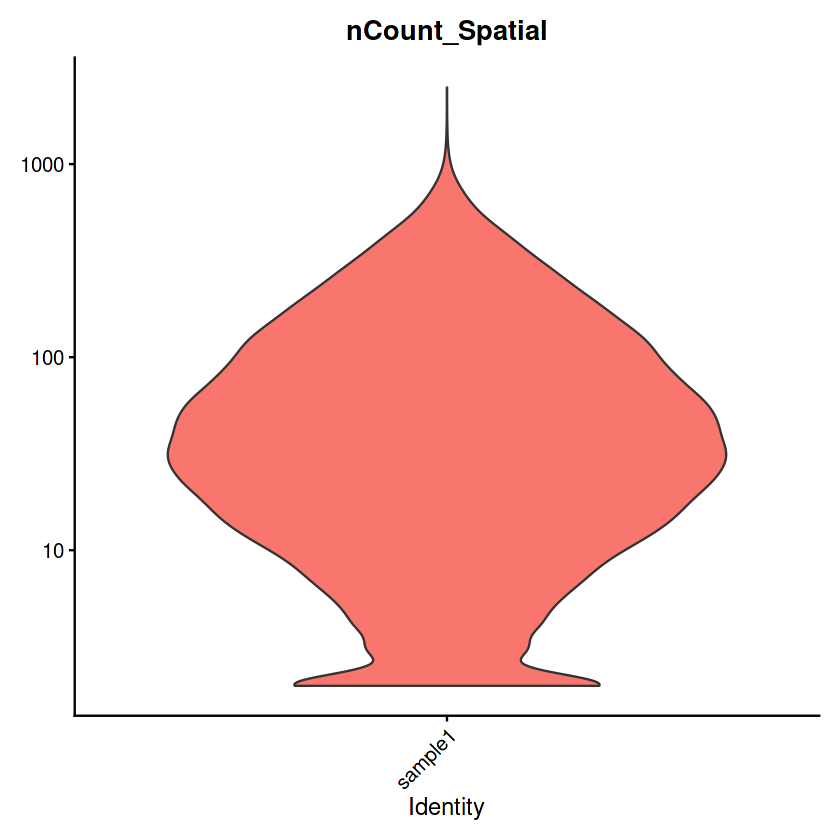

In [4]:
obj %>%
   Seurat::VlnPlot(., features="nCount_Spatial", pt.size=0, log=TRUE) +
   Seurat::NoLegend() -> vln_count_plot

ggplot2::ggsave("output/violin_count.png", vln_count_plot, width=9, height=6)
ggplot2::ggsave("output/violin_count.pdf", vln_count_plot, width=9, height=6)

vln_count_plot

### UMIs

UMIs per bead.

Warning message:
“`guides(<scale> = FALSE)` is deprecated. Please use `guides(<scale> = "none")` instead.”


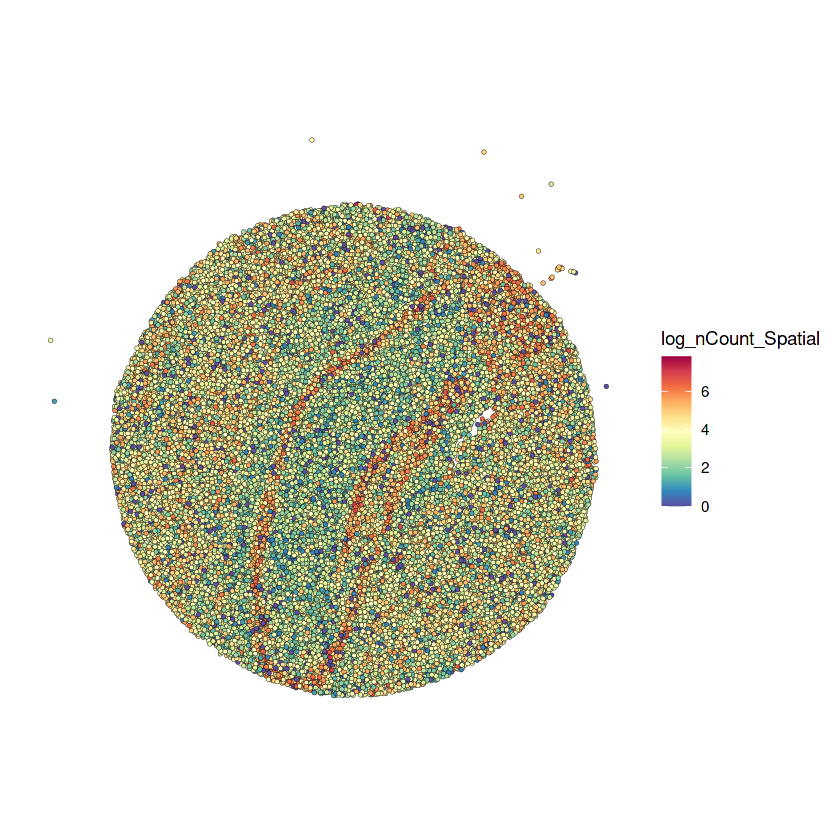

In [5]:
obj %>%
   Seurat::SpatialFeaturePlot(., features="log_nCount_Spatial") +
   ggplot2::theme(legend.position="right") -> spatial_umi_plot

ggplot2::ggsave("output/spatial_umi.png", spatial_umi_plot, width=9, height=6)
ggplot2::ggsave("output/spatial_umi.pdf", spatial_umi_plot, width=9, height=6)

spatial_umi_plot

### Percentage of mitochondria

Distribution of percentage of detected mitochondrial genes.

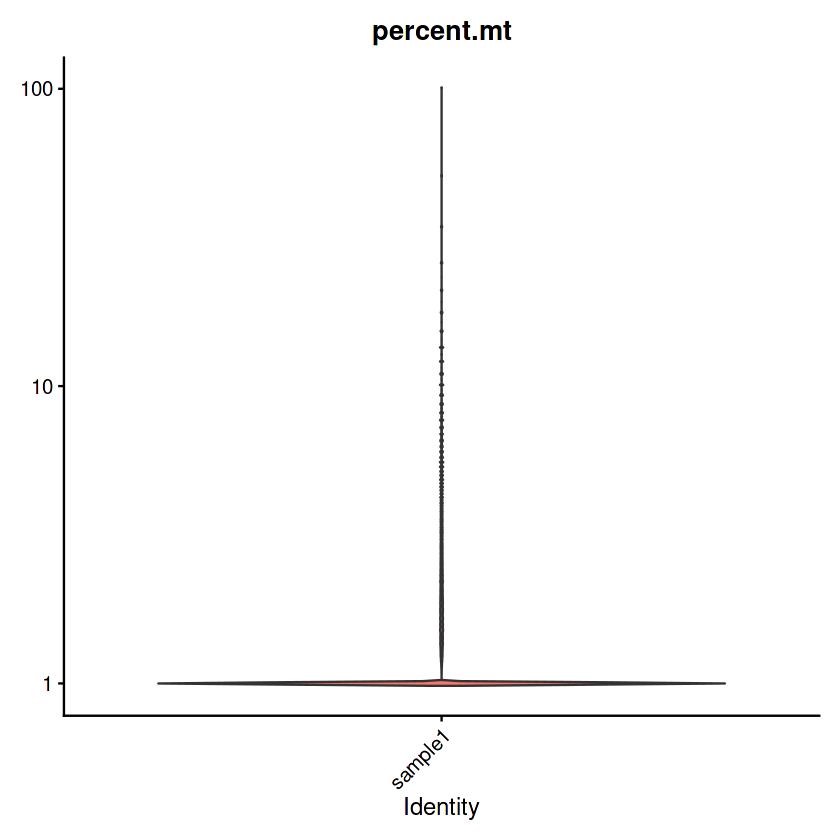

In [6]:
obj[["percent.mt"]] <- Seurat::PercentageFeatureSet(obj, pattern="^mt-")

obj %>%
   Seurat::VlnPlot(., features="percent.mt", pt.size=0, log=TRUE) +
   Seurat::NoLegend() -> vln_mitoch_plot

ggplot2::ggsave("output/violin_mitoch.png", vln_mitoch_plot, width=9, height=6)
ggplot2::ggsave("output/violin_mitoch.pdf", vln_mitoch_plot, width=9, height=6)

vln_mitoch_plot

### Abnormal beads

Gene counts vers mitochondrial percentage

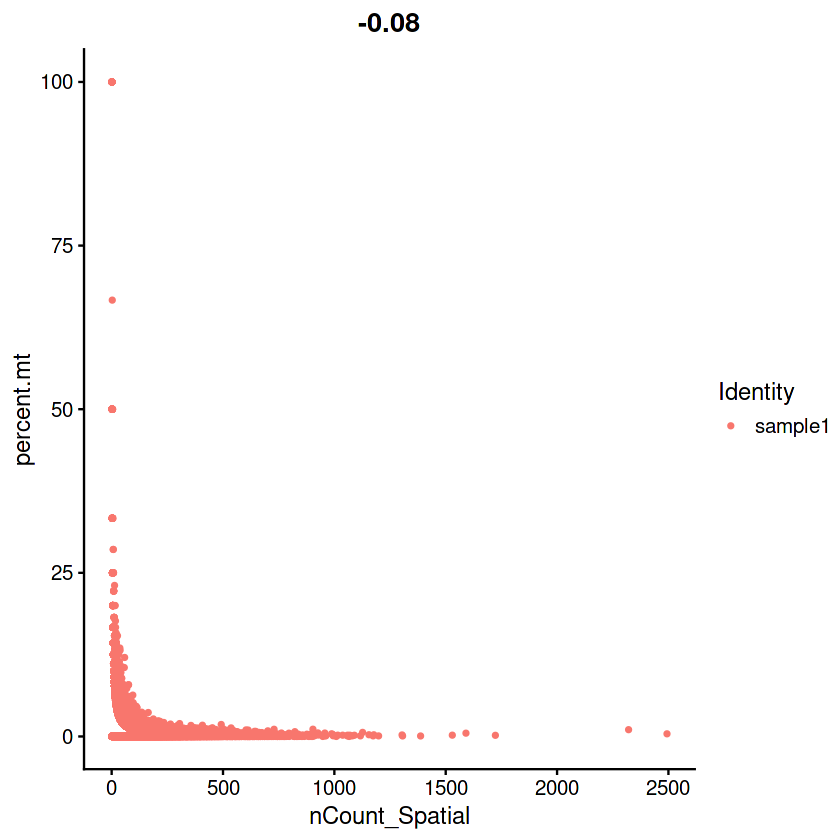

In [7]:
scatter_plot <-
   Seurat::FeatureScatter(
      obj,
      feature1="nCount_Spatial",
      feature2="percent.mt"
   )

ggplot2::ggsave("output/scatter_count_mitoch.png", scatter_plot, width=9, height=6)
ggplot2::ggsave("output/scatter_count_mitoch.pdf", scatter_plot, width=9, height=6)

scatter_plot

## Filtering

We remove abnormal cells.

In [8]:
cat("Original\n")
print(obj)

cat("Filter mitochondria\n")
obj <- base::subset(obj, percent.mt < 30)
print(obj)

cat("Filter UMIs\n")
obj <- base::subset(obj, nCount_Spatial >= 10)
print(obj)

Original
An object of class Seurat 
54838 features across 42236 samples within 1 assay 
Active assay: Spatial (54838 features, 0 variable features)
Filter mitochondria


Warning message:
“Keys should be one or more alphanumeric characters followed by an underscore, setting key from _images to images_”


An object of class Seurat 
54838 features across 42138 samples within 1 assay 
Active assay: Spatial (54838 features, 0 variable features)
Filter UMIs
An object of class Seurat 
54838 features across 33050 samples within 1 assay 
Active assay: Spatial (54838 features, 0 variable features)


## Clustering

In [9]:
obj <- Seurat::SCTransform(obj, assay="Spatial", ncells=3000, verbose=T)

Calculating cell attributes from input UMI matrix: log_umi

Variance stabilizing transformation of count matrix of size 19053 by 33050

Model formula is y ~ log_umi

Get Negative Binomial regression parameters per gene

Using 2000 genes, 3000 cells



  |======================================================================| 100%


Found 59 outliers - those will be ignored in fitting/regularization step


Second step: Get residuals using fitted parameters for 19053 genes



  |======================================================================| 100%


Computing corrected count matrix for 19053 genes



  |======================================================================| 100%


Calculating gene attributes

Wall clock passed: Time difference of 2.670761 mins

Determine variable features

Place corrected count matrix in counts slot

Centering data matrix

Set default assay to SCT

Warning message:
“Invalid name supplied, making object name syntactically valid. New object name is Seurat..SCTransform.Spatial; see ?make.names for more details on syntax validity”


In [10]:
obj <- Seurat::RunPCA(obj)

PC_ 1 
Positive:  Plp1, Cnp, Fth1, Mobp, Mal, Qk, Ermn, Mbp, Pde4b, Mag 
	   Mog, Tspan2, Prr5l, Cldn11, mt-Rnr2, Car2, Opalin, Apod, Enpp2, Tmeff2 
	   Bcas1, St18, Sept4, Kif5a, Anln, Ugt8a, Erbin, Gjc3, Scd2, Aspa 
Negative:  Kcnip4, Rbfox1, Nrg3, Lsamp, Opcml, Nrxn3, Csmd1, Dlg2, Tenm2, Lrrtm4 
	   Celf2, Fgf14, Cadm2, Cntnap2, Kcnd2, Lrrc7, Epha6, Nrg1, Kcnma1, Nlgn1 
	   Adgrb3, Gm28928, Nrxn1, Dlgap1, Asic2, Kcnq5, Hs6st3, Lingo2, Pde4d, Nav3 
PC_ 2 
Positive:  Pcdh9, Pde4b, Plp1, Nkain2, Ptprd, Tmeff2, Kcnip4, Magi2, St18, Mobp 
	   Mal, Prr5l, Rbfox1, Slc24a2, Rnf220, Cnp, Dock10, Ermn, Lrp1b, Mag 
	   Fnbp1, Mog, Plcl1, Tspan2, Cldn11, Aspa, Fa2h, Mbp, Nrg3, Ano4 
Negative:  mt-Rnr2, Myo3a, Ddn, mt-Nd5, Slc1a2, mt-Cytb, Cst3, mt-Nd2, Ddx10, Ttr 
	   Rps24, Olfr1044, Rpl9, Rps21, mt-Rnr1, Rpl36a, Rpl31, Gas5, Fau, mt-Nd6 
	   mt-Co1, Ndufs1, mt-Nd1, Catsperd, Map2, mt-Nd4, Rps20, Rpl37, Chd3, Rps14 
PC_ 3 
Positive:  Gpc5, Lsamp, Npas3, Slc1a2, Nrxn1, Slc1a3, Ntm, Gm3764, Rora

In [11]:
obj <- Seurat::RunUMAP(obj, dims=1:10)

Warning message:
“The default method for RunUMAP has changed from calling Python UMAP via reticulate to the R-native UWOT using the cosine metric
To use Python UMAP via reticulate, set umap.method to 'umap-learn' and metric to 'correlation'
This message will be shown once per session”
12:10:41 UMAP embedding parameters a = 0.9922 b = 1.112

12:10:41 Read 33050 rows and found 10 numeric columns

12:10:41 Using Annoy for neighbor search, n_neighbors = 30

12:10:41 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

12:10:45 Writing NN index file to temp file /tmp/slurm_48010405/RtmpG9188X/file48b250392dc

12:10:45 Searching Annoy index using 1 thread, search_k = 3000

12:10:58 Annoy recall = 100%

12:11:00 Commencing smooth kNN distance calibration using 1 thread

12:11:02 I

In [12]:
obj <- Seurat::FindNeighbors(obj, dims=1:10)

Computing nearest neighbor graph

Computing SNN



In [13]:
BiocParallel::register(MulticoreParam(12))
base::options(future.globals.maxSize = 5000 * 1024^2)
future::plan("multiprocess", workers=12)

obj <- Seurat::FindClusters(obj, resolution=0.1, verbose=T)

Warning message:
“Strategy 'multiprocess' is deprecated in future (>= 1.20.0) [2020-10-30]. Instead, explicitly specify either 'multisession' (recommended) or 'multicore'. In the current R session, 'multiprocess' equals 'multicore'.”


Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 33050
Number of edges: 874151

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9237
Number of communities: 8
Elapsed time: 7 seconds
R_zmq_msg_send errno: 4 strerror: Interrupted system call


Warning message:
“UNRELIABLE VALUE: One of the ‘future.apply’ iterations (‘future_lapply-1’) unexpectedly generated random numbers without declaring so. There is a risk that those random numbers are not statistically sound and the overall results might be invalid. To fix this, specify 'future.seed=TRUE'. This ensures that proper, parallel-safe random numbers are produced via the L'Ecuyer-CMRG method. To disable this check, use 'future.seed = NULL', or set option 'future.rng.onMisuse' to "ignore".”


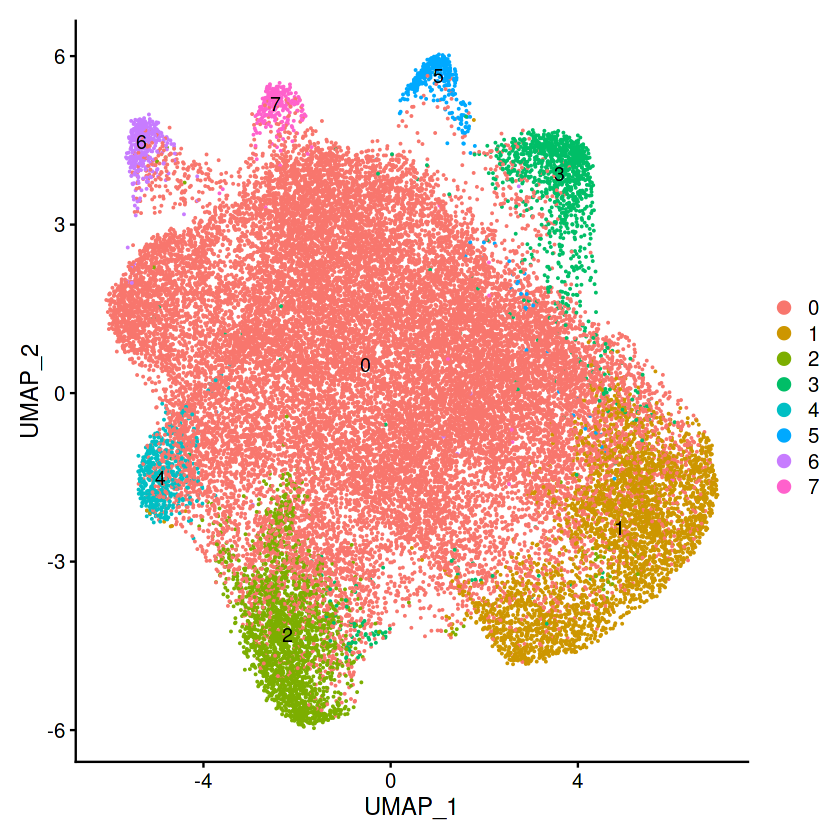

In [14]:
umap_plot <- Seurat::DimPlot(obj, reduction="umap", label=TRUE)

ggplot2::ggsave("output/umap.png", umap_plot, width=9, height=6)
ggplot2::ggsave("output/umap.pdf", umap_plot, width=9, height=6)

umap_plot

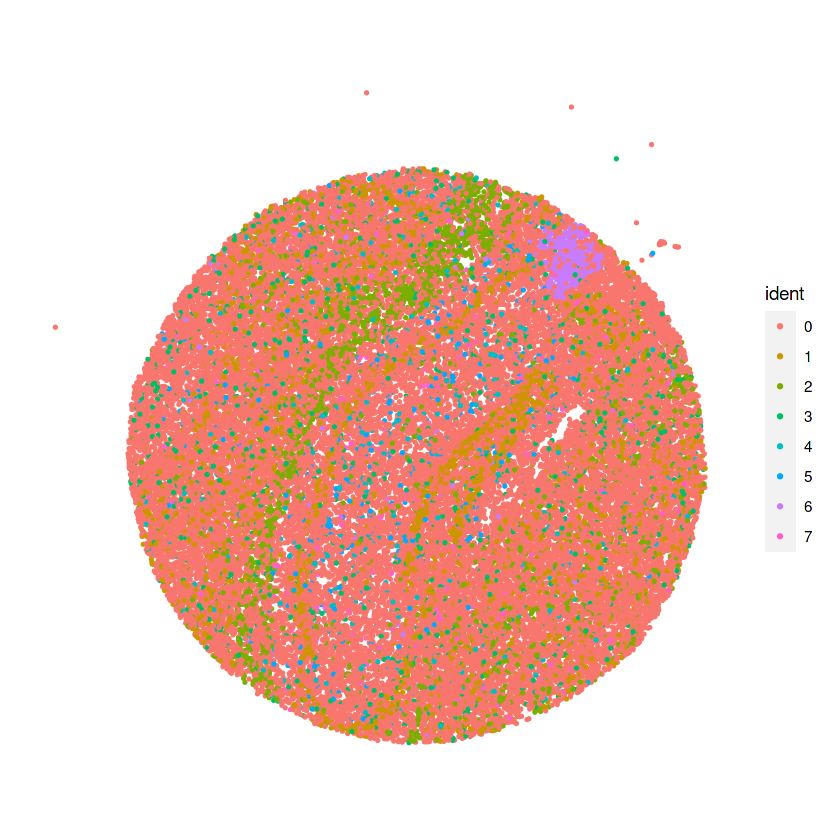

In [15]:
spatial_cluster_plot <- Seurat::SpatialDimPlot(obj, stroke=0)

ggplot2::ggsave("output/spatial.png", spatial_cluster_plot, width=9, height=6)
ggplot2::ggsave("output/spatial.pdf", spatial_cluster_plot, width=9, height=6)

spatial_cluster_plot

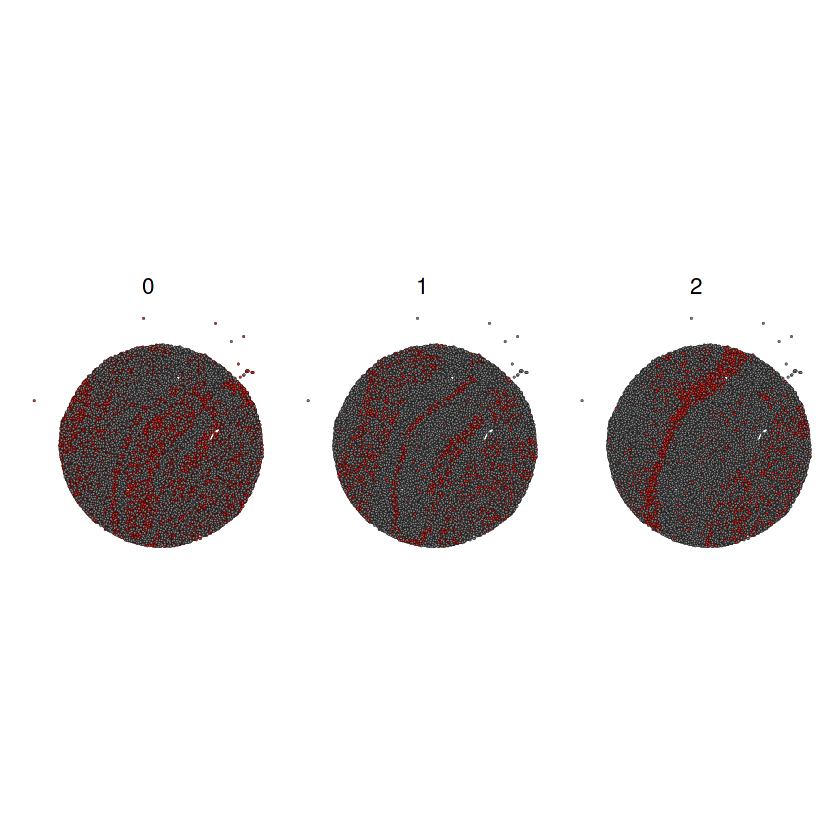

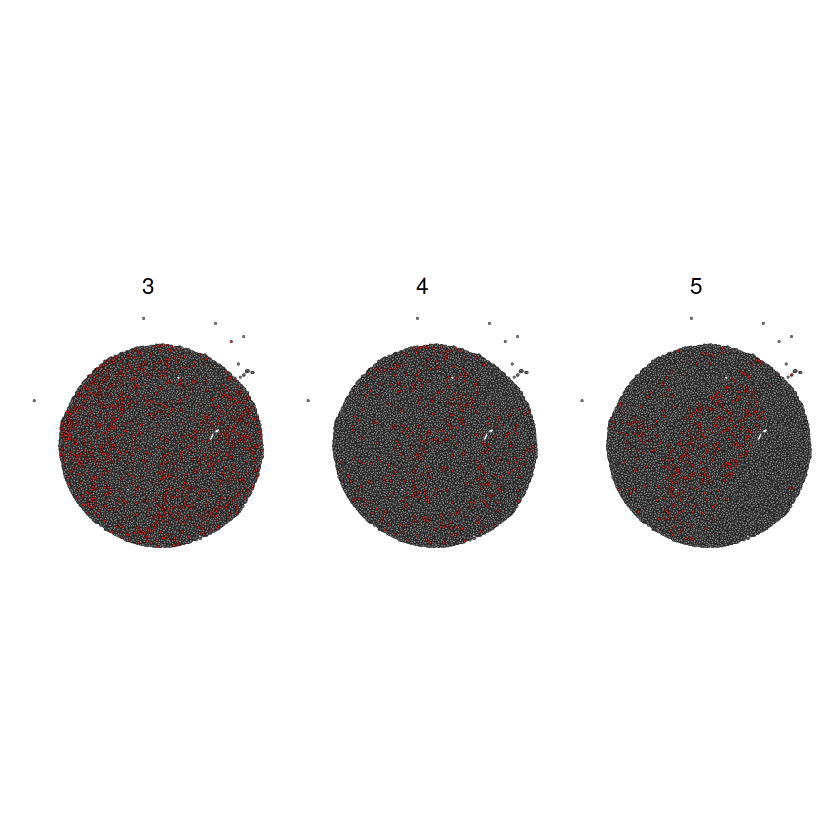

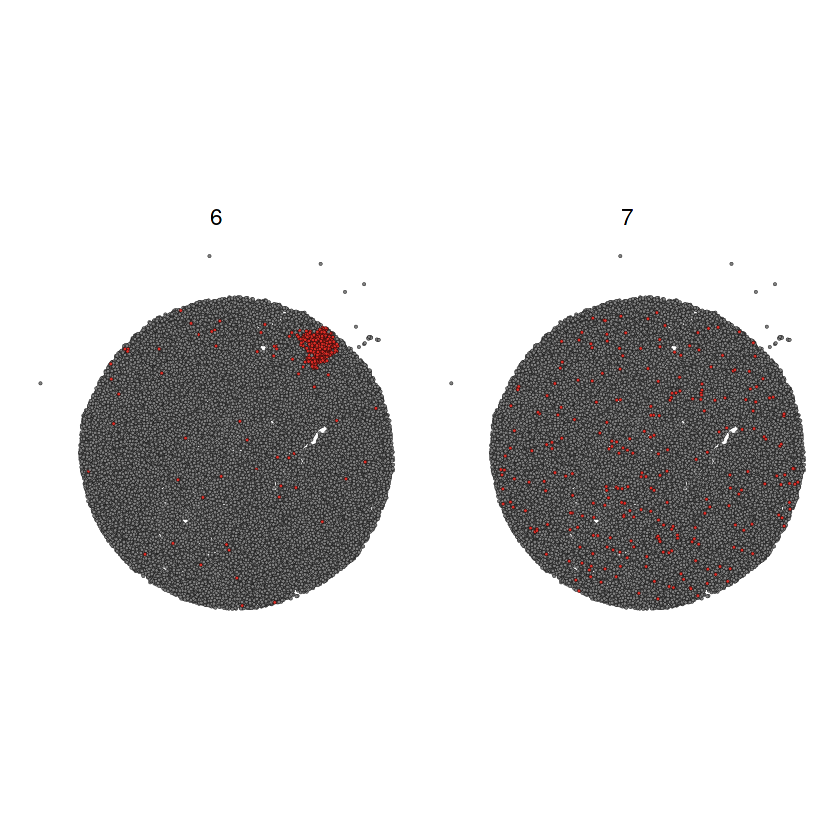

In [16]:
obj %>%
   slot(., "meta.data") %>%
   dplyr::pull(paste0("SCT_snn_res.", 0.1)) %>%
   levels() %>%
   as.numeric(.) %>%
   sort() -> clusters


ncol <- 3
1:ceiling( length(clusters) / ncol) %>%
   purrr::map(function(x) ncol * (x-1) + 1:ncol) %>%
   purrr::map(function(x) clusters[x]) %>%
   purrr::map(function(x) {

      plot <- Seurat::SpatialDimPlot(
         obj,
         cells.highlight=Seurat::CellsByIdentities(object=obj, idents=x),
         facet.highlight=T
      )

      basename <- paste0("output/individual_cluster_", paste(na.omit(x), collapse="-"))

      ggplot2::ggsave(
         filename=paste0(basename, ".png"),
         plot=plot,
         widt=9, height=6, dpi=300
         )

      ggplot2::ggsave(
         filename=paste0(basename, ".pdf"),
         plot=plot,
         widt=9, height=6, dpi=300
         )

      print(plot)

      list("clusters"=x, "plot"=plot)

   }) -> clusters_plots

## Marker genes

In [17]:
markers <- Seurat::FindAllMarkers(obj, assay="SCT", only.pos=T)
write.csv(markers, "output/markers.csv", row.names=F)
markers

Calculating cluster 0

Warning message in FindMarkers.default(object = data.use, slot = data.slot, counts = counts, :
“No features pass logfc.threshold threshold; returning empty data.frame”
Calculating cluster 1



R_zmq_msg_send errno: 4 strerror: Interrupted system call
R_zmq_msg_send errno: 4 strerror: Interrupted system call
R_zmq_msg_send errno: 4 strerror: Interrupted system call
R_zmq_msg_send errno: 4 strerror: Interrupted system call
R_zmq_msg_send errno: 4 strerror: Interrupted system call


Calculating cluster 2



R_zmq_msg_send errno: 4 strerror: Interrupted system call
R_zmq_msg_send errno: 4 strerror: Interrupted system call


Calculating cluster 3



R_zmq_msg_send errno: 4 strerror: Interrupted system call
R_zmq_msg_send errno: 4 strerror: Interrupted system call


Calculating cluster 4



R_zmq_msg_send errno: 4 strerror: Interrupted system call
R_zmq_msg_send errno: 4 strerror: Interrupted system call
R_zmq_msg_send errno: 4 strerror: Interrupted system call
R_zmq_msg_send errno: 4 strerror: Interrupted system call
R_zmq_msg_send errno: 4 strerror: Interrupted system call
R_zmq_msg_send errno: 4 strerror: Interrupted system call
R_zmq_msg_send errno: 4 strerror: Interrupted system call
R_zmq_msg_send errno: 4 strerror: Interrupted system call


Calculating cluster 5



R_zmq_msg_send errno: 4 strerror: Interrupted system call


Calculating cluster 6



R_zmq_msg_send errno: 4 strerror: Interrupted system call
R_zmq_msg_send errno: 4 strerror: Interrupted system call
R_zmq_msg_send errno: 4 strerror: Interrupted system call


Calculating cluster 7



R_zmq_msg_send errno: 4 strerror: Interrupted system call


p_val         avg_log2FC pct.1 pct.2 p_val_adj     cluster gene   
Kcnip4   0.000000e+00 0.5094008  0.269 0.014  0.000000e+00 1       Kcnip4 
Rbfox1   0.000000e+00 0.3972738  0.221 0.021  0.000000e+00 1       Rbfox1 
Lsamp    0.000000e+00 0.3302666  0.224 0.050  0.000000e+00 1       Lsamp  
Dlg2     0.000000e+00 0.2585266  0.158 0.020  0.000000e+00 1       Dlg2   
Nrg3     0.000000e+00 0.2572007  0.157 0.014  0.000000e+00 1       Nrg3   
Plp1     0.000000e+00 0.3164521  0.228 0.010  0.000000e+00 2       Plp1   
Pcdh9   1.547949e-173 0.2712075  0.174 0.041 2.949308e-169 2       Pcdh9  
Zc3h7a   0.000000e+00 0.8173934  0.586 0.005  0.000000e+00 3       Zc3h7a 
Mir6236  0.000000e+00 0.3076848  0.194 0.003  0.000000e+00 3       Mir6236
Lsamp1   0.000000e+00 1.0453034  0.545 0.061  0.000000e+00 4       Lsamp  
Gpc5     0.000000e+00 0.6721083  0.383 0.010  0.000000e+00 4       Gpc5   
Npas3    0.000000e+00 0.3348285  0.194 0.007  0.000000e+00 4       Npas3  
Nrxn1   5.002264e-188 0.5387766  0.297 0.038 9.530814e-184 4       Nrxn1  
Slc1a3  1.460477e-186 0.2693408  0.186 0.015 2.782647e-182 4       Slc1a3 
Ntm     1.125080e-166 0.4362712  0.277 0.036 2.143615e-162 4       Ntm    
Slc1a2  1.075543e-112 0.3410948  0.232 0.036 2.049233e-108 4       Slc1a2 
Rora    1.437859e-102 0.2630702  0.192 0.027  2.739552e-98 4       Rora   
Ddn      0.000000e+00 1.0561041  0.865 0.000  0.000000e+00 5       Ddn    
Ttr      0.000000e+00 1.0269949  0.741 0.000  0.000000e+00 6       Ttr    
Enpp2    0.000000e+00 0.5882136  0.405 0.006  0.000000e+00 6       Enpp2  
Trpm3   1.942053e-161 0.2880558  0.208 0.017 3.700194e-157 6       Trpm3  
mt-Nd4   0.000000e+00 1.1115196  0.935 0.002  0.000000e+00 7       mt-Nd4

Selecting by gene


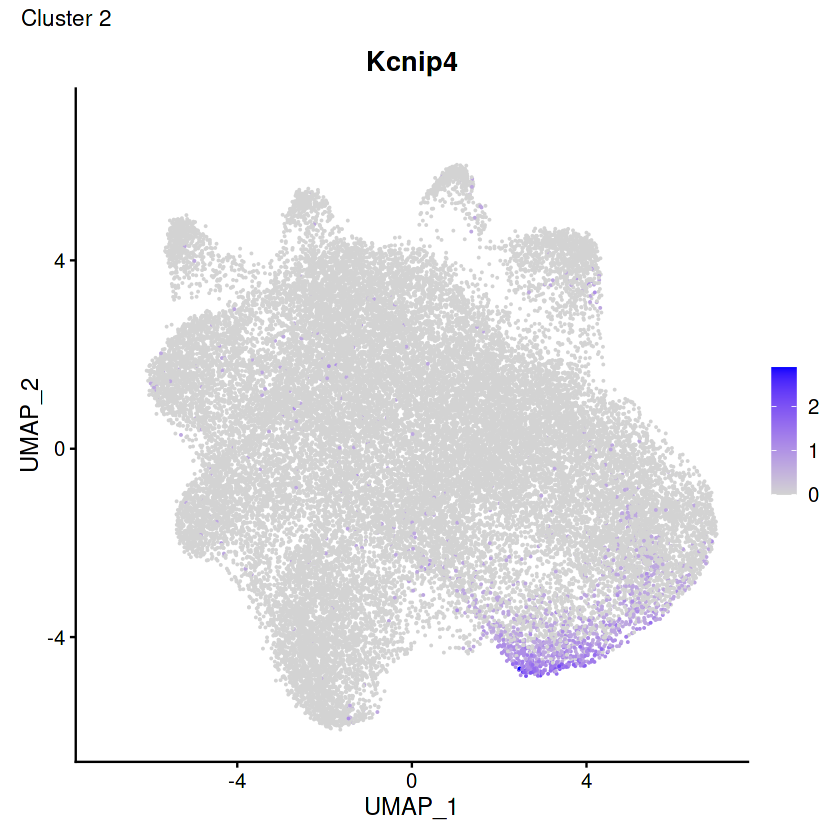

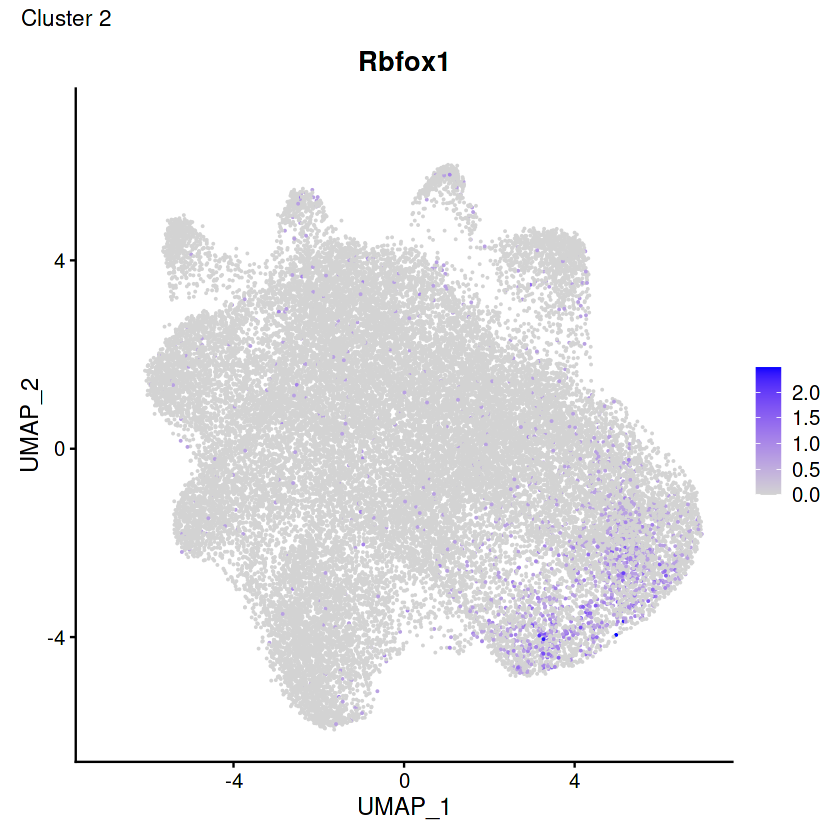

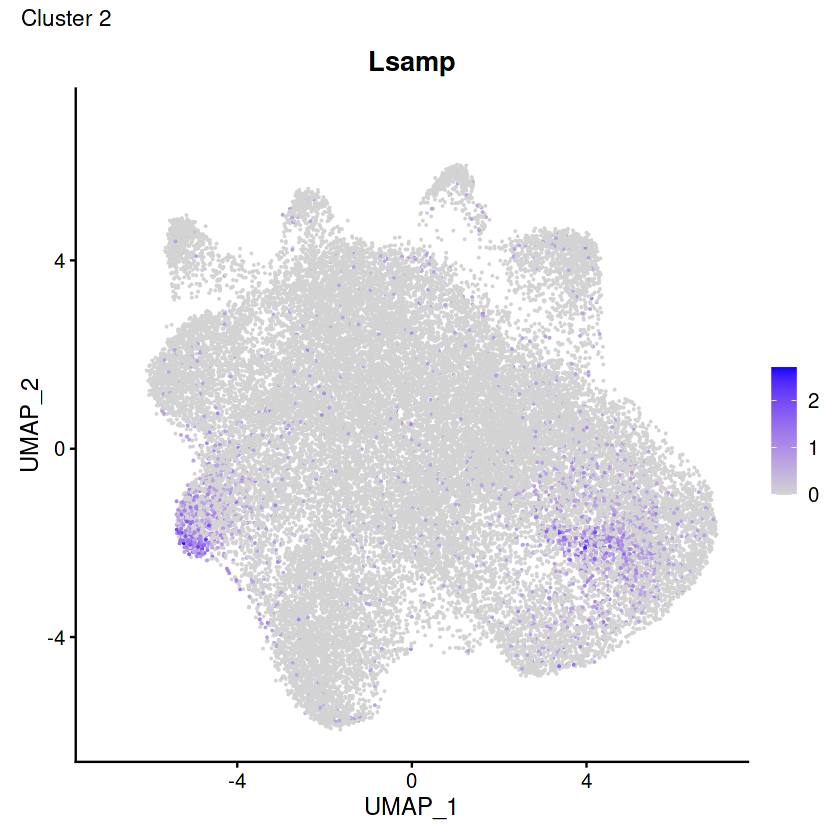

Selecting by gene


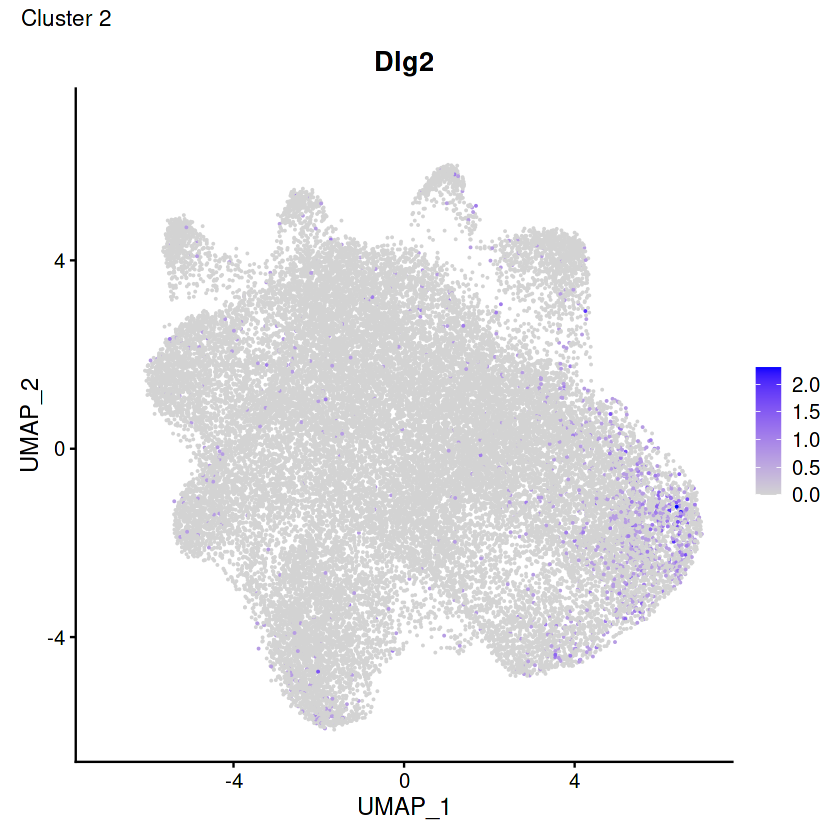

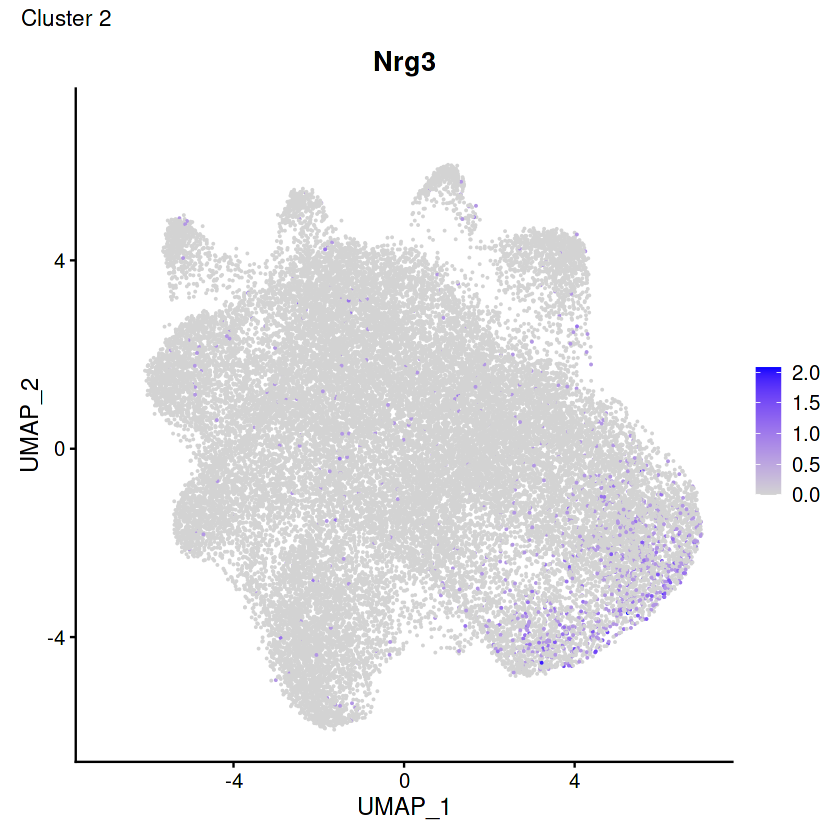

Selecting by gene


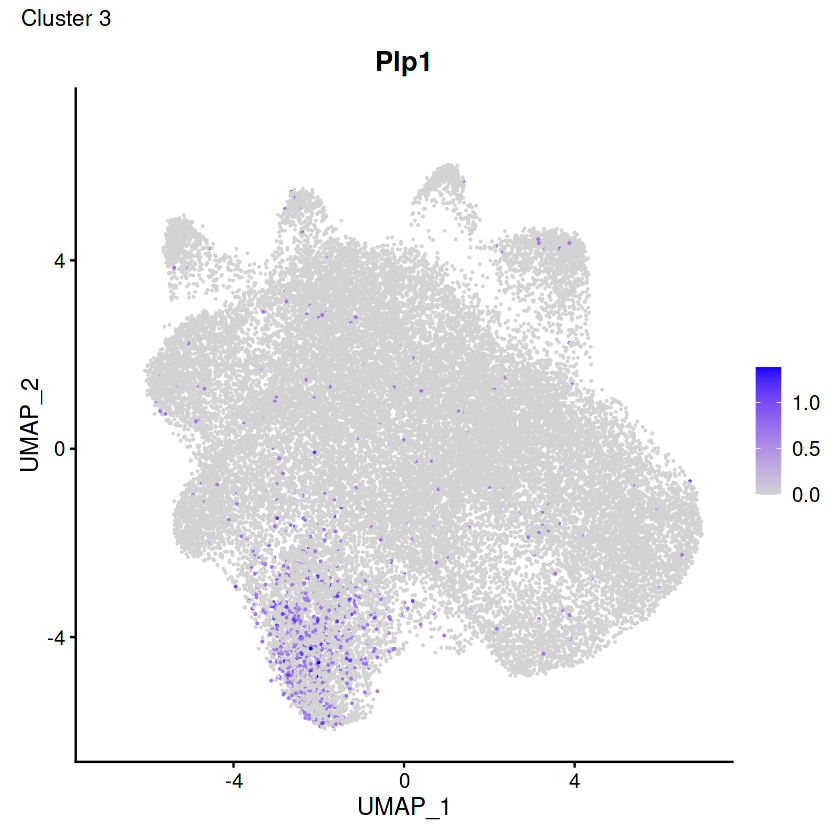

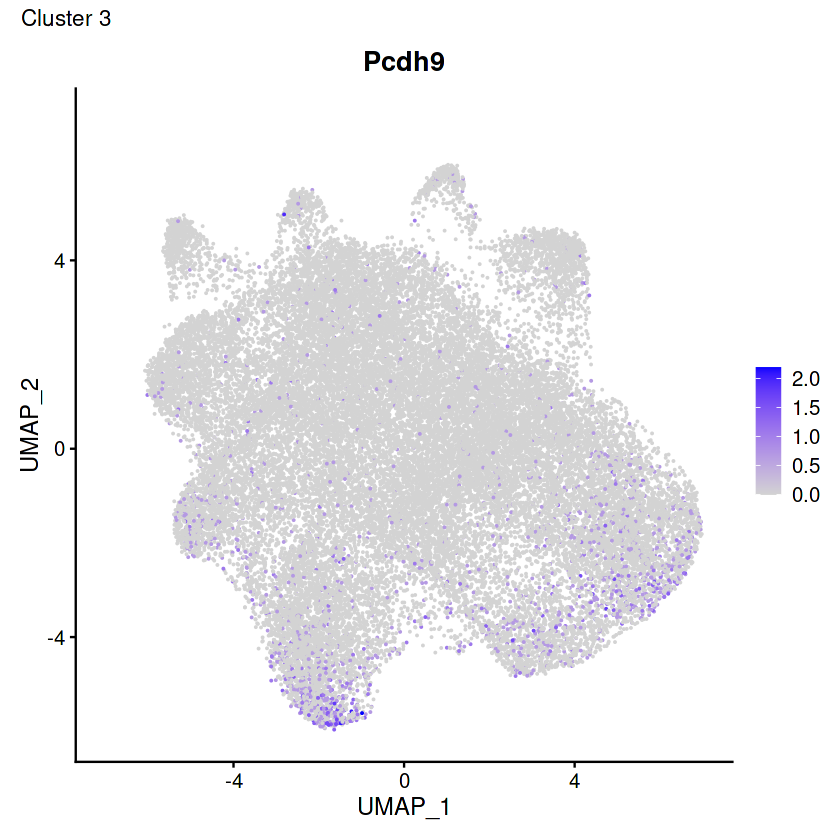

Selecting by gene


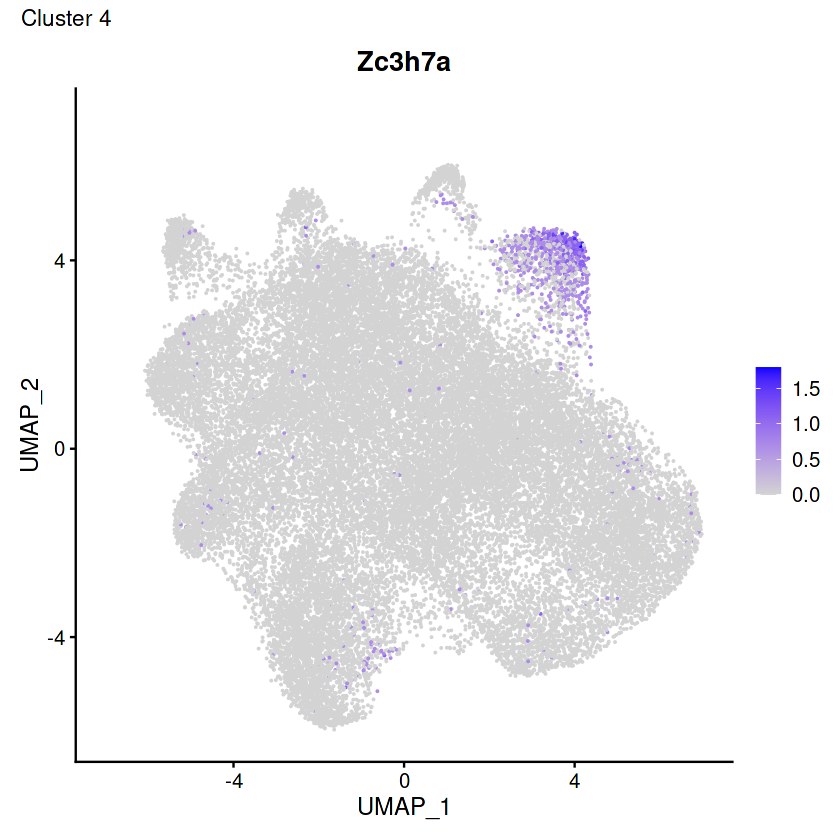

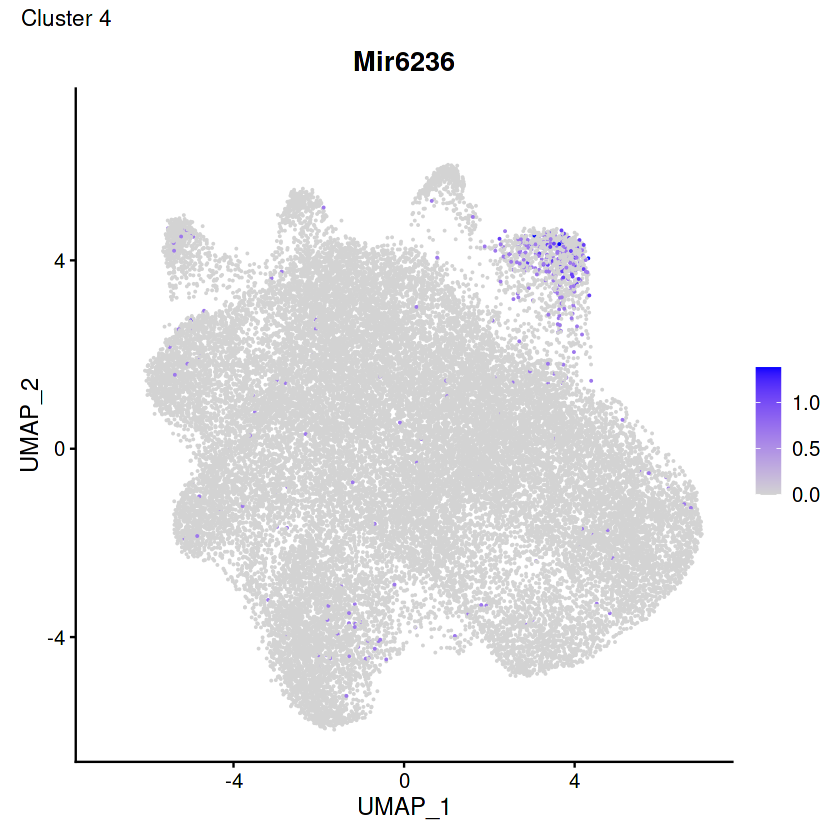

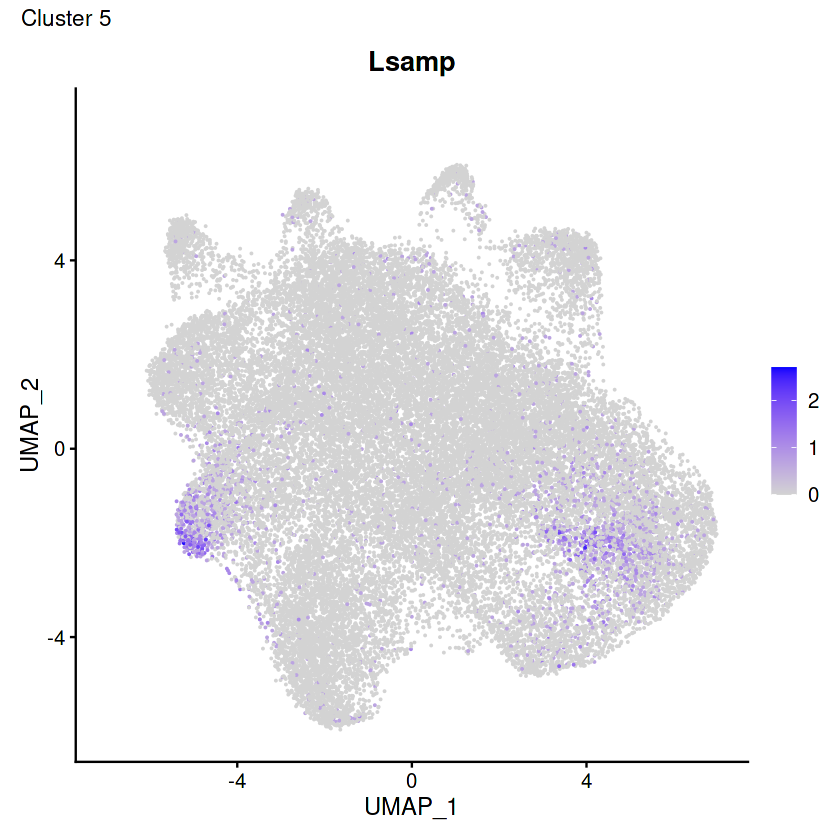

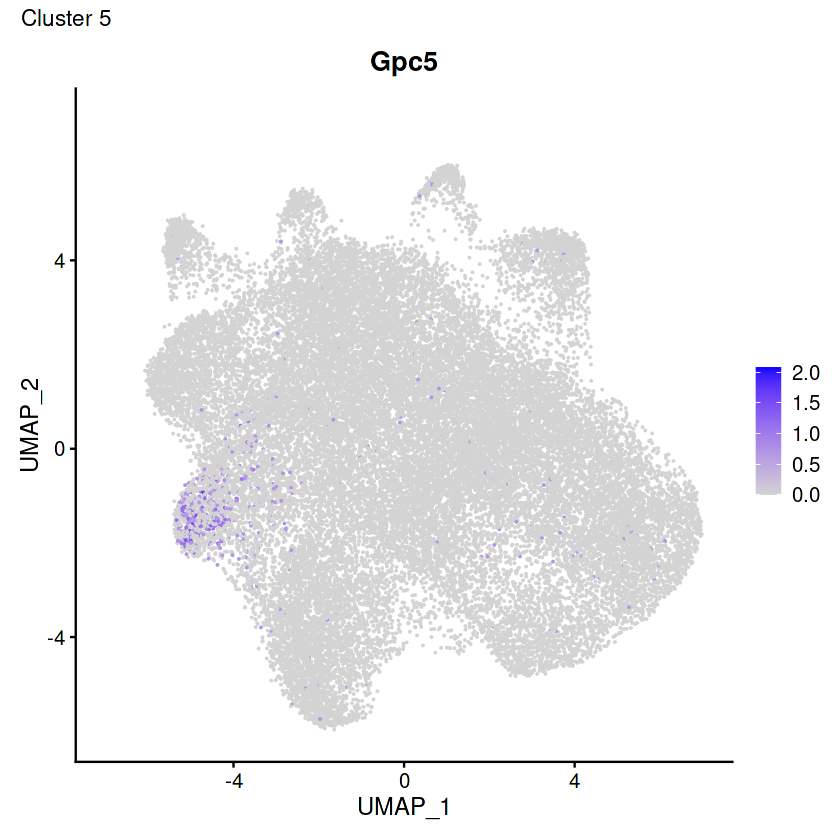

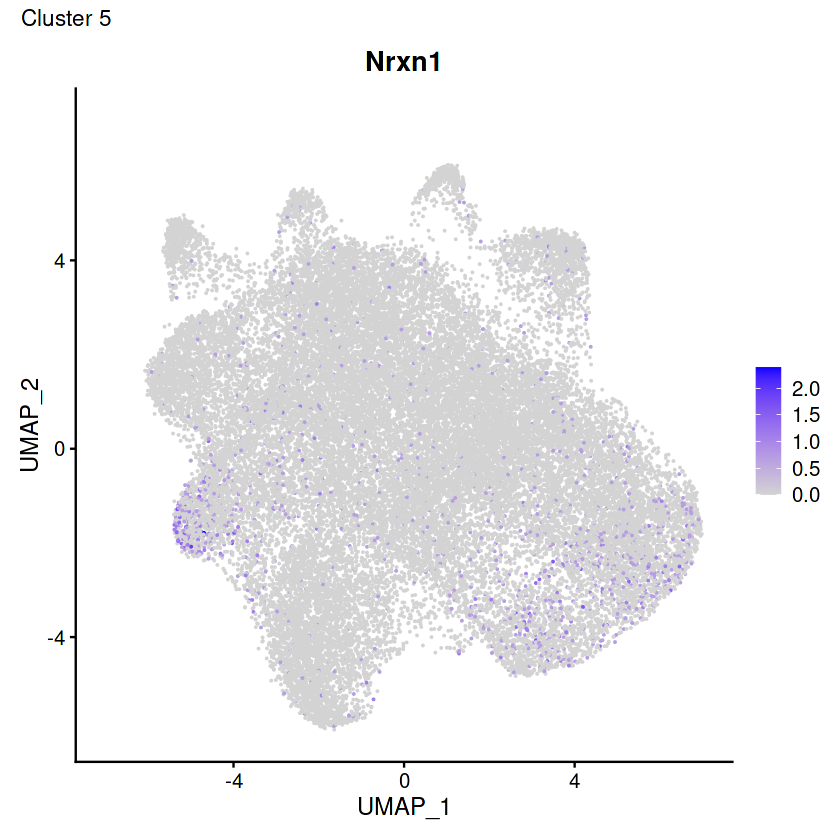

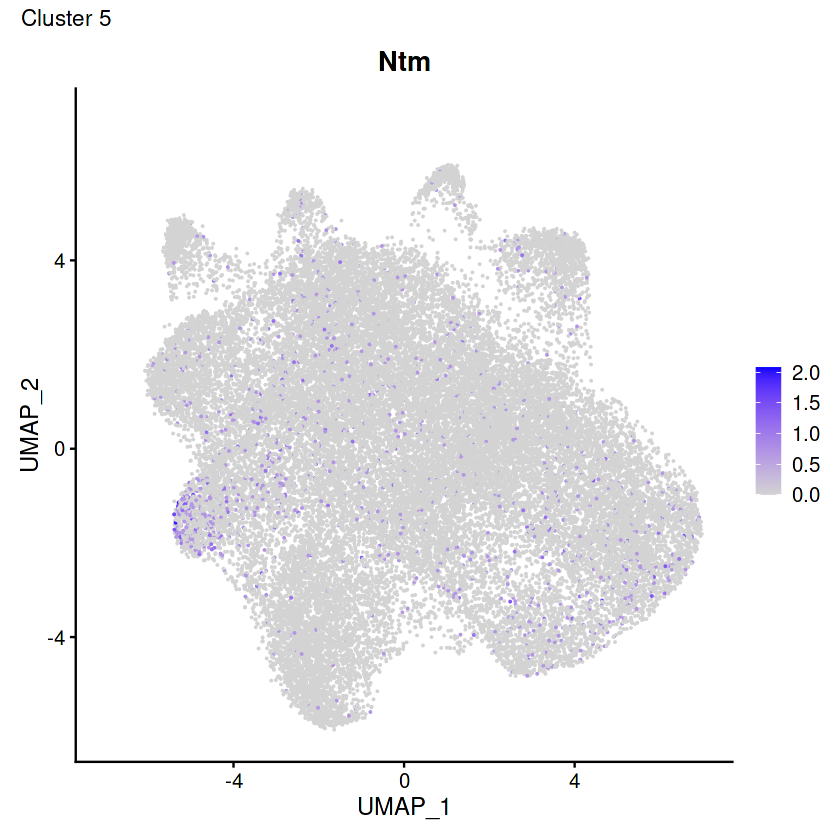

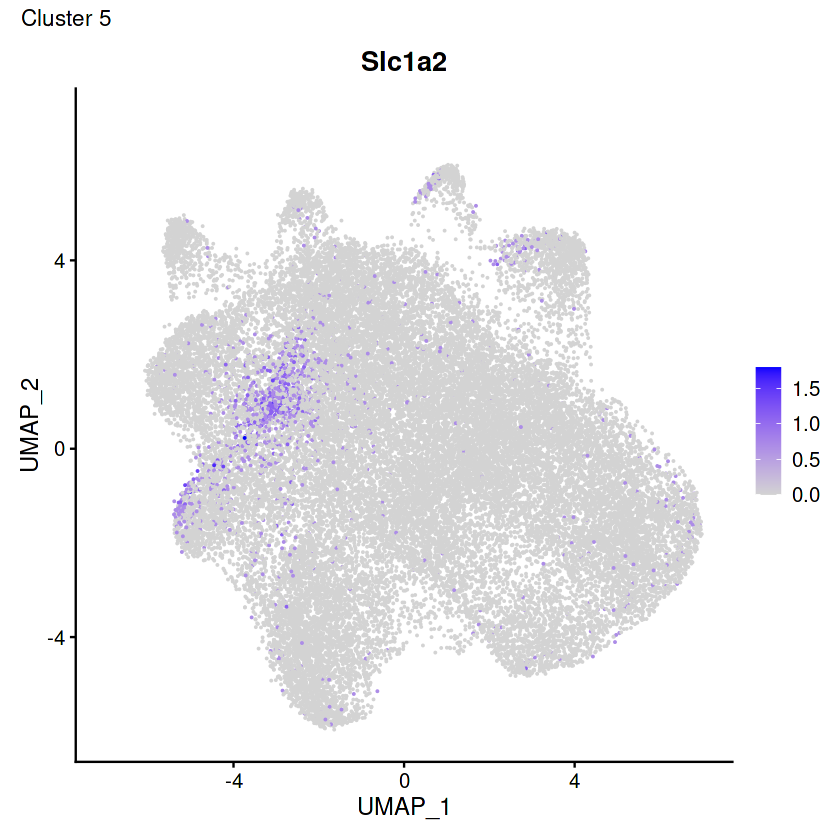

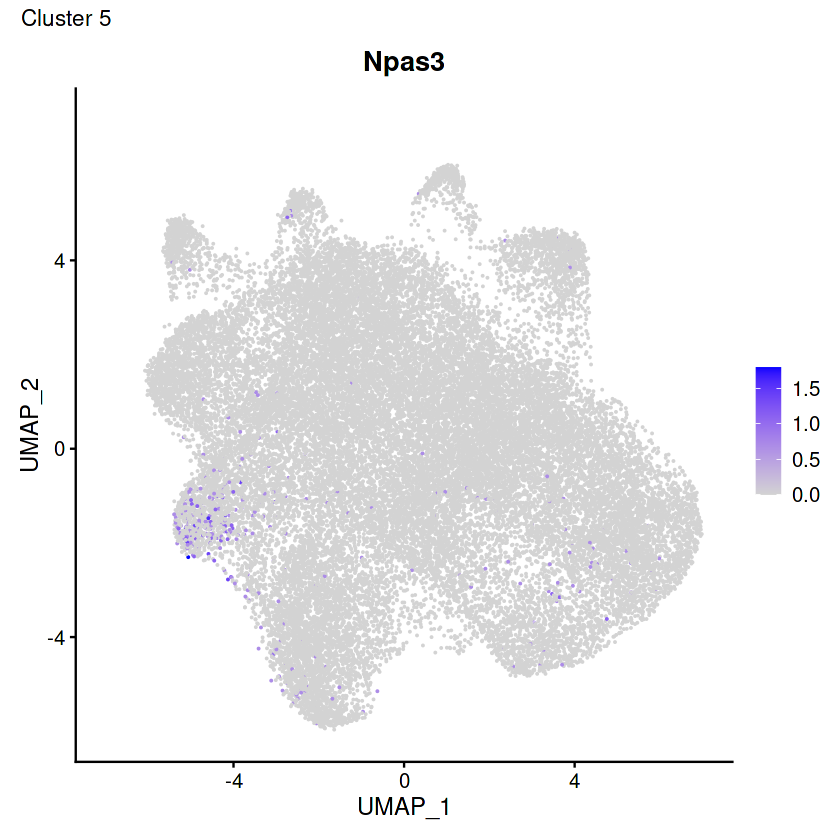

Selecting by gene


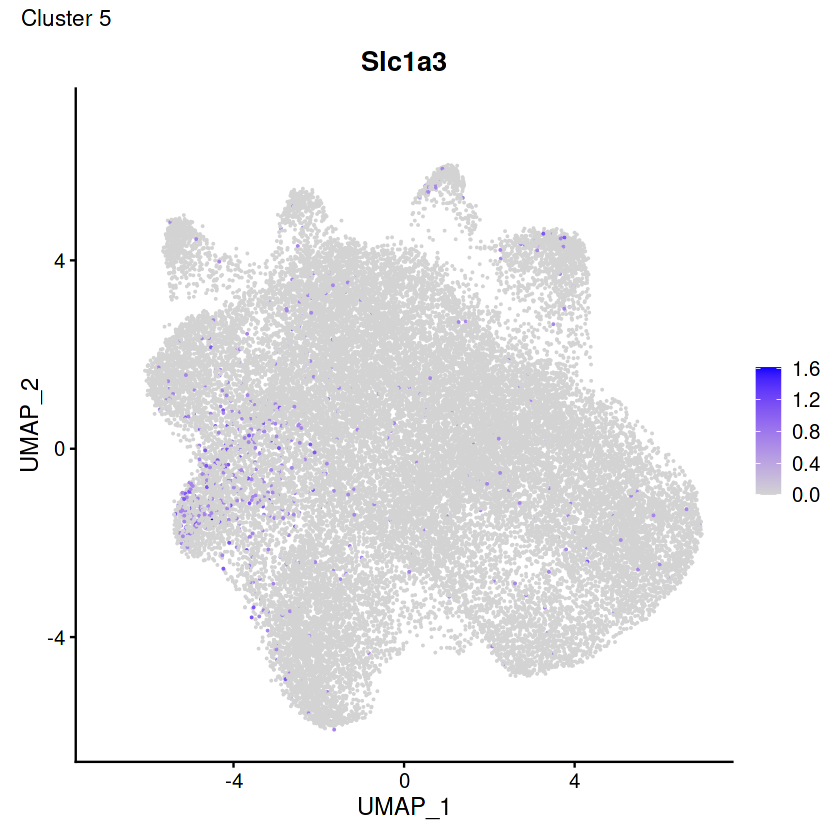

Selecting by gene


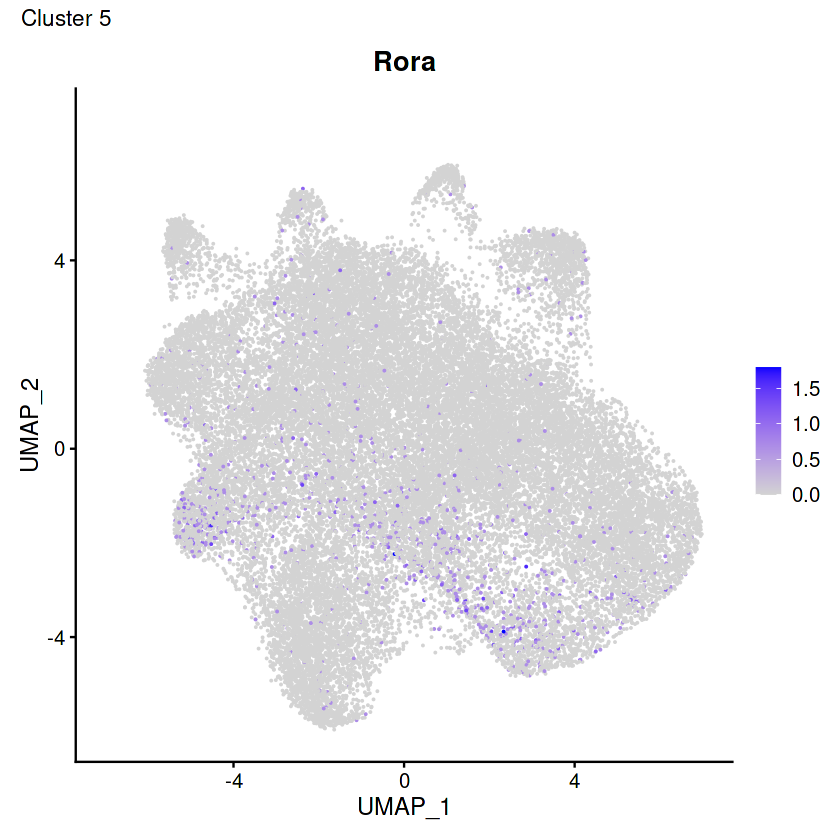

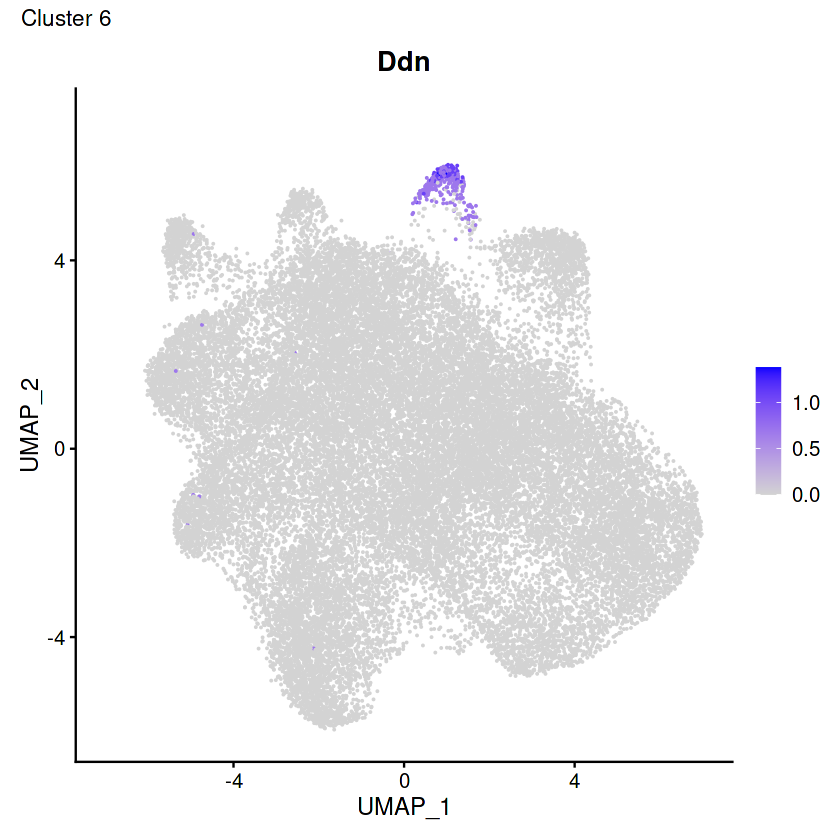

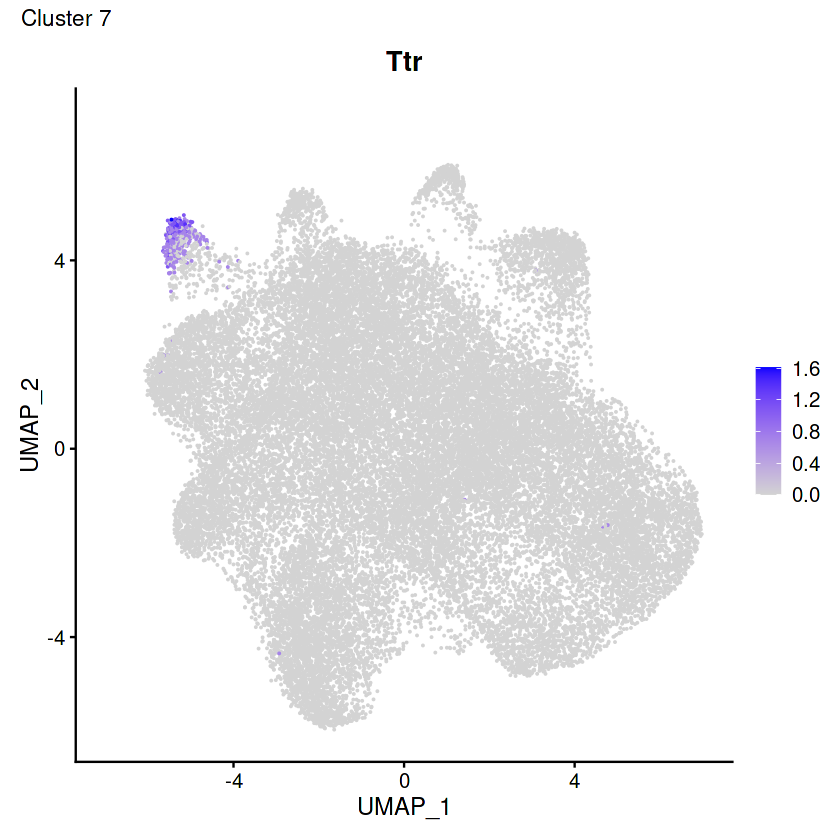

Selecting by gene


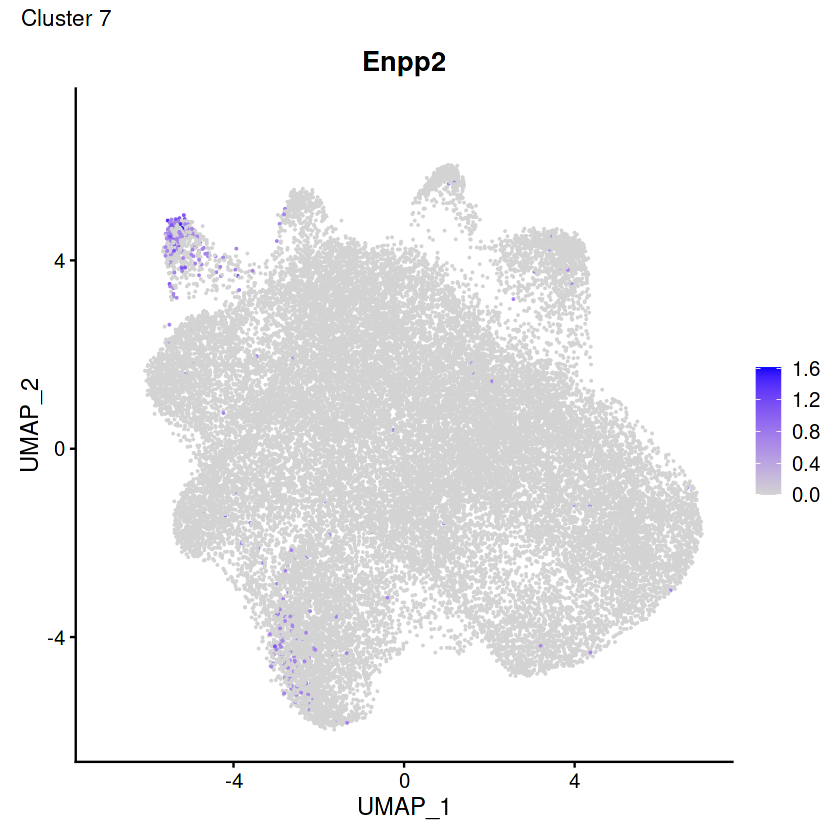

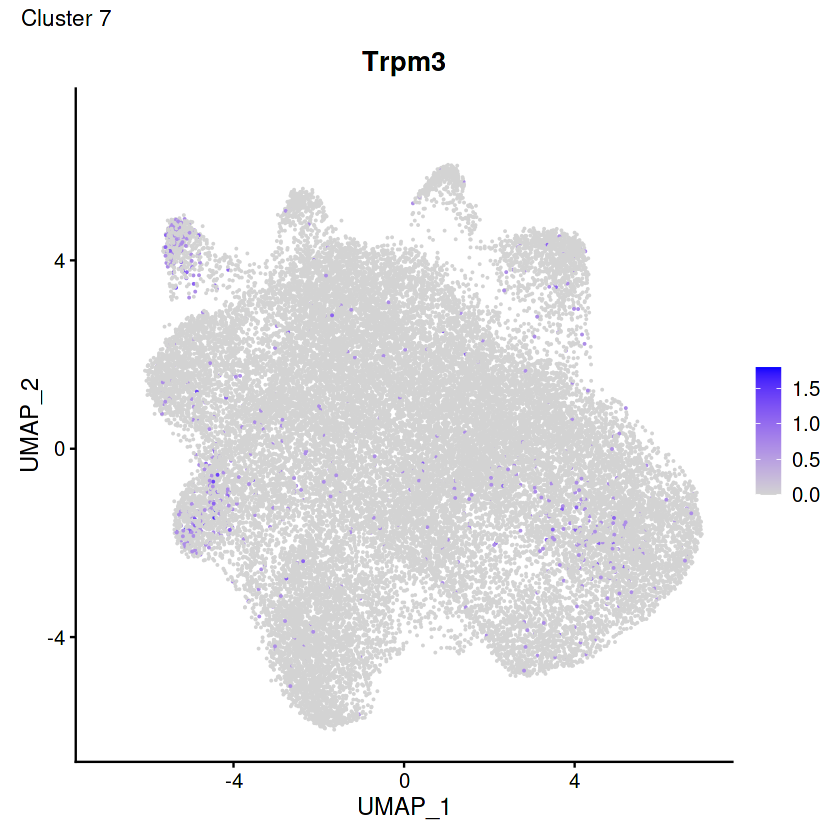

[[1]]
NULL

[[2]]
NULL

[[3]]
NULL

[[4]]
NULL

[[5]]
NULL

[[6]]
NULL

[[7]]
NULL

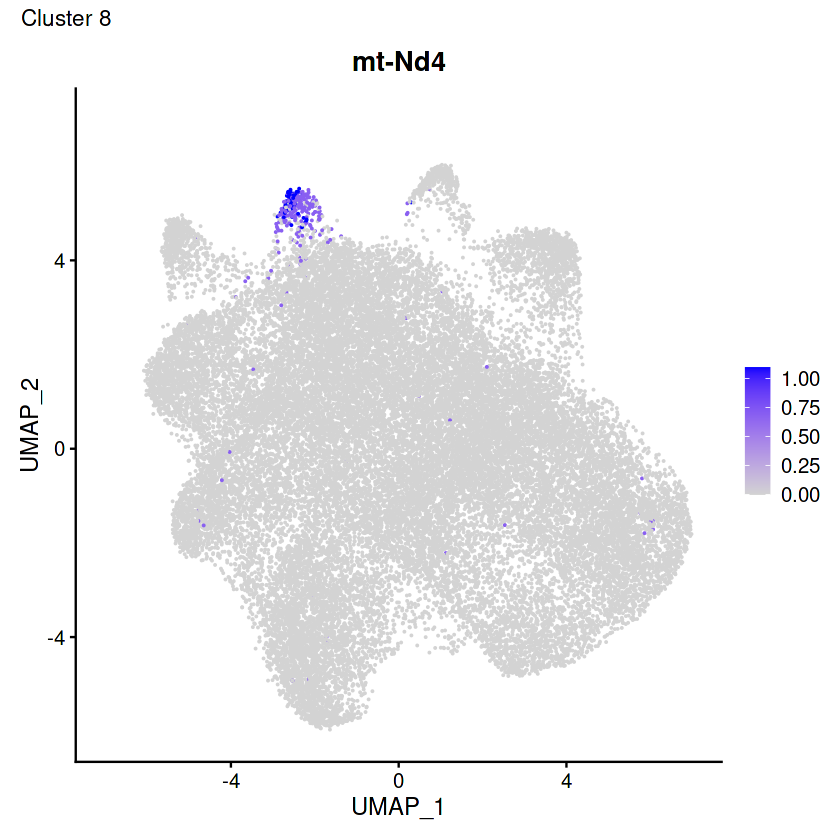

In [18]:
if ( nrow(markers) > 0 )
{
   markers %>%
      dplyr::group_by(cluster) %>%
      dplyr::group_map(function(x, n) {
   
         df <-
            x %>%
            dplyr::arrange(dplyr::desc(avg_log2FC) ) %>%
            dplyr::top_n( max(6, nrow(x)) )
   
         genes <- df$gene
   
         for ( gene in genes ) {
   
            g <- Seurat::FeaturePlot(obj, features=gene, ncol=1)
            g <- g + patchwork::plot_annotation(title=paste0("Cluster ", n))
   
            ggplot2::ggsave(
               filename=sprintf("output/markers_cluster_%s_gene_%s.png", n, gene),
               plot=g,
               height=3, width=3.5, dpi=200
               )
   
            ggplot2::ggsave(
               filename=sprintf("output/markers_cluster_%s_gene_%s.pdf", n, gene),
               plot=g,
               height=3, width=3.5, dpi=200
               )
   
            print(g)
         }
      })
}

## Save

In [19]:
saveRDS(obj, "output/seurat_object.rds")

sceasy::convertFormat(
   obj,
   from="seurat",
   to="anndata",
   assay="Spatial",
   outFile="output/seurat_object.h5ad"
   )

Warning message in .regularise_df(obj@meta.data, drop_single_values = drop_single_values):
“Dropping single category variables:orig.ident”


AnnData object with n_obs × n_vars = 33050 × 54838
    obs: 'nCount_Spatial', 'nFeature_Spatial', 'x', 'y', 'log_nCount_Spatial', 'percent.mt', 'nCount_SCT', 'nFeature_SCT', 'SCT_snn_res.0.1', 'seurat_clusters'
    var: 'name'
    obsm: 'X_pca', 'X_umap'

## Session info

In [20]:
sessionInfo()

R version 4.2.1 (2022-06-23)
Platform: x86_64-pc-linux-gnu (64-bit)
Running under: Ubuntu Kinetic Kudu (development branch)

Matrix products: default
BLAS:   /usr/lib/x86_64-linux-gnu/openblas-pthread/libblas.so.3
LAPACK: /usr/lib/x86_64-linux-gnu/openblas-pthread/libopenblasp-r0.3.20.so

locale:
 [1] LC_CTYPE=C.UTF-8    LC_NUMERIC=C        LC_TIME=C          
 [4] LC_COLLATE=C        LC_MONETARY=C       LC_MESSAGES=C      
 [7] LC_PAPER=C          LC_NAME=C           LC_ADDRESS=C       
[10] LC_TELEPHONE=C      LC_MEASUREMENT=C    LC_IDENTIFICATION=C

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
 [1] sceasy_0.0.6        reticulate_1.25     purrr_0.3.4        
 [4] patchwork_1.1.1     ggplot2_3.3.6       future_1.26.1      
 [7] dplyr_1.0.9         SeuratObject_4.0.4  Seurat_4.1.0       
[10] BiocParallel_1.30.3

loaded via a namespace (and not attached):
  [1] Rtsne_0.16            colorspace_2.0-3      del